In [1]:
# Import required modules

import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

In [2]:
"""
Get unlimited data from the API v2.1

Parameters:
dataset_id (string): dataset if as from city of Melbourne (https://data.melbourne.vic.gov.au/)

Returns:
Pandas Dataframe: Returns the dataset in shape of pandas dataframe
"""
def Get_Dataset(dataset_id): # pass in dataset id 
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets'

    format = 'csv'

    url = f'{base_url}/{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC'
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset 
    else:
        return (print(f'Request failed with status code {response.status_code}'))

### Microclimate Dataset

In [3]:
# Get the first dataset 
microclimate_sensors_df = Get_Dataset('microclimate-sensors-data')
microclimate_sensors_df.head()

,device_id,received_at,sensorlocation,latlong,minimumwinddirection,averagewinddirection,maximumwinddirection,minimumwindspeed,averagewindspeed,gustwindspeed,airtemperature,relativehumidity,atmosphericpressure,pm25,pm10,noise
0,ICTMicroclimate-07,2024-06-12T05:58:33+00:00,Tram Stop 7C - Melbourne Tennis Centre Precinc...,"-37.8222341, 144.9829409",0.0,297.0,358.0,0.0,0.9,3.6,12.5,57.2,1020.9,2.0,2.0,76.2
1,ICTMicroclimate-03,2024-06-12T05:58:16+00:00,CH1 rooftop,"-37.8140348, 144.96728",166.0,199.0,215.0,2.9,3.4,6.4,11.9,62.5,1013.6,2.0,4.0,82.5
2,aws5-0999,2024-06-12T05:36:39+00:00,Royal Park Asset ID: COM2707,"-37.7956167, 144.9519007",0.0,77.0,112.0,0.9,0.2,2.0,11.6,56.9,1016.8,NaN,NaN,NaN
3,ICTMicroclimate-09,2024-06-12T05:55:29+00:00,SkyFarm (Jeff's Shed). Rooftop - Melbourne Con...,"-37.8223306, 144.9521696",0.0,233.0,359.0,0.0,2.2,6.7,12.3,57.7,1017.7,1.0,2.0,66.5
4,ICTMicroclimate-02,2024-06-12T06:04:45+00:00,101 Collins St L11 Rooftop,"-37.814604, 144.9702991",0.0,150.0,314.0,0.0,1.1,2.0,12.9,60.4,1014.6,4.0,7.0,71.4


In [4]:
print(microclimate_sensors_df.info())
print("\n\nMissing values:")
print(microclimate_sensors_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46322 entries, 0 to 46321
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   device_id             46322 non-null  object 
 1   received_at           46322 non-null  object 
 2   sensorlocation        45519 non-null  object 
 3   latlong               45519 non-null  object 
 4   minimumwinddirection  40278 non-null  float64
 5   averagewinddirection  46304 non-null  float64
 6   maximumwinddirection  40278 non-null  float64
 7   minimumwindspeed      40278 non-null  float64
 8   averagewindspeed      46304 non-null  float64
 9   gustwindspeed         40278 non-null  float64
 10  airtemperature        46304 non-null  float64
 11  relativehumidity      46304 non-null  float64
 12  atmosphericpressure   46304 non-null  float64
 13  pm25                  42122 non-null  float64
 14  pm10                  42122 non-null  float64
 15  noise              

In [5]:
microclimate_sensors_df.fillna({
    'sensorlocation': 'Unknown',
    'minimumwinddirection': microclimate_sensors_df['minimumwinddirection'].median(),
    'averagewinddirection': microclimate_sensors_df['averagewinddirection'].median(),
    'maximumwinddirection': microclimate_sensors_df['maximumwinddirection'].median(),
    'minimumwindspeed': microclimate_sensors_df['minimumwindspeed'].median(),
    'averagewindspeed': microclimate_sensors_df['averagewindspeed'].median(),
    'gustwindspeed': microclimate_sensors_df['gustwindspeed'].median(),
    'airtemperature': microclimate_sensors_df['airtemperature'].median(),
    'relativehumidity': microclimate_sensors_df['relativehumidity'].median(),
    'atmosphericpressure': microclimate_sensors_df['atmosphericpressure'].median(),
    'pm25': microclimate_sensors_df['pm25'].median(),
    'pm10': microclimate_sensors_df['pm10'].median(),
    'noise': microclimate_sensors_df['noise'].median()
}, inplace=True)

# Extracting Lat & Long
microclimate_sensors_df[['lat', 'long']] = microclimate_sensors_df['latlong'].str.split(',', expand=True).astype(float)
# Dropping the original LatLong column
microclimate_sensors_df.drop(columns=['latlong'], inplace=True)
# Using KNNImputer to fill missing Latitude and Longitude values with the nearest available values
microclimate_sensors_df[['lat', 'long']] = KNNImputer(n_neighbors=5).fit_transform(microclimate_sensors_df[['lat', 'long']])


# Converting the 'Time' column to datetime
microclimate_sensors_df['received_at'] = pd.to_datetime(microclimate_sensors_df['received_at'])
# Extracting additional time-related features
microclimate_sensors_df['Year'] = microclimate_sensors_df['received_at'].dt.year
microclimate_sensors_df['Month'] = microclimate_sensors_df['received_at'].dt.month
microclimate_sensors_df['Day'] = microclimate_sensors_df['received_at'].dt.day
microclimate_sensors_df['Hour'] = microclimate_sensors_df['received_at'].dt.hour
microclimate_sensors_df['Minute'] = microclimate_sensors_df['received_at'].dt.minute
microclimate_sensors_df['Second'] = microclimate_sensors_df['received_at'].dt.second

# Displaying the first few rows of the processed microclimate_sensors_df
print(microclimate_sensors_df.info())
print("\n\nMissing values:")
print(microclimate_sensors_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46322 entries, 0 to 46321
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   device_id             46322 non-null  object             
 1   received_at           46322 non-null  datetime64[ns, UTC]
 2   sensorlocation        46322 non-null  object             
 3   minimumwinddirection  46322 non-null  float64            
 4   averagewinddirection  46322 non-null  float64            
 5   maximumwinddirection  46322 non-null  float64            
 6   minimumwindspeed      46322 non-null  float64            
 7   averagewindspeed      46322 non-null  float64            
 8   gustwindspeed         46322 non-null  float64            
 9   airtemperature        46322 non-null  float64            
 10  relativehumidity      46322 non-null  float64            
 11  atmosphericpressure   46322 non-null  float64            
 12  pm25

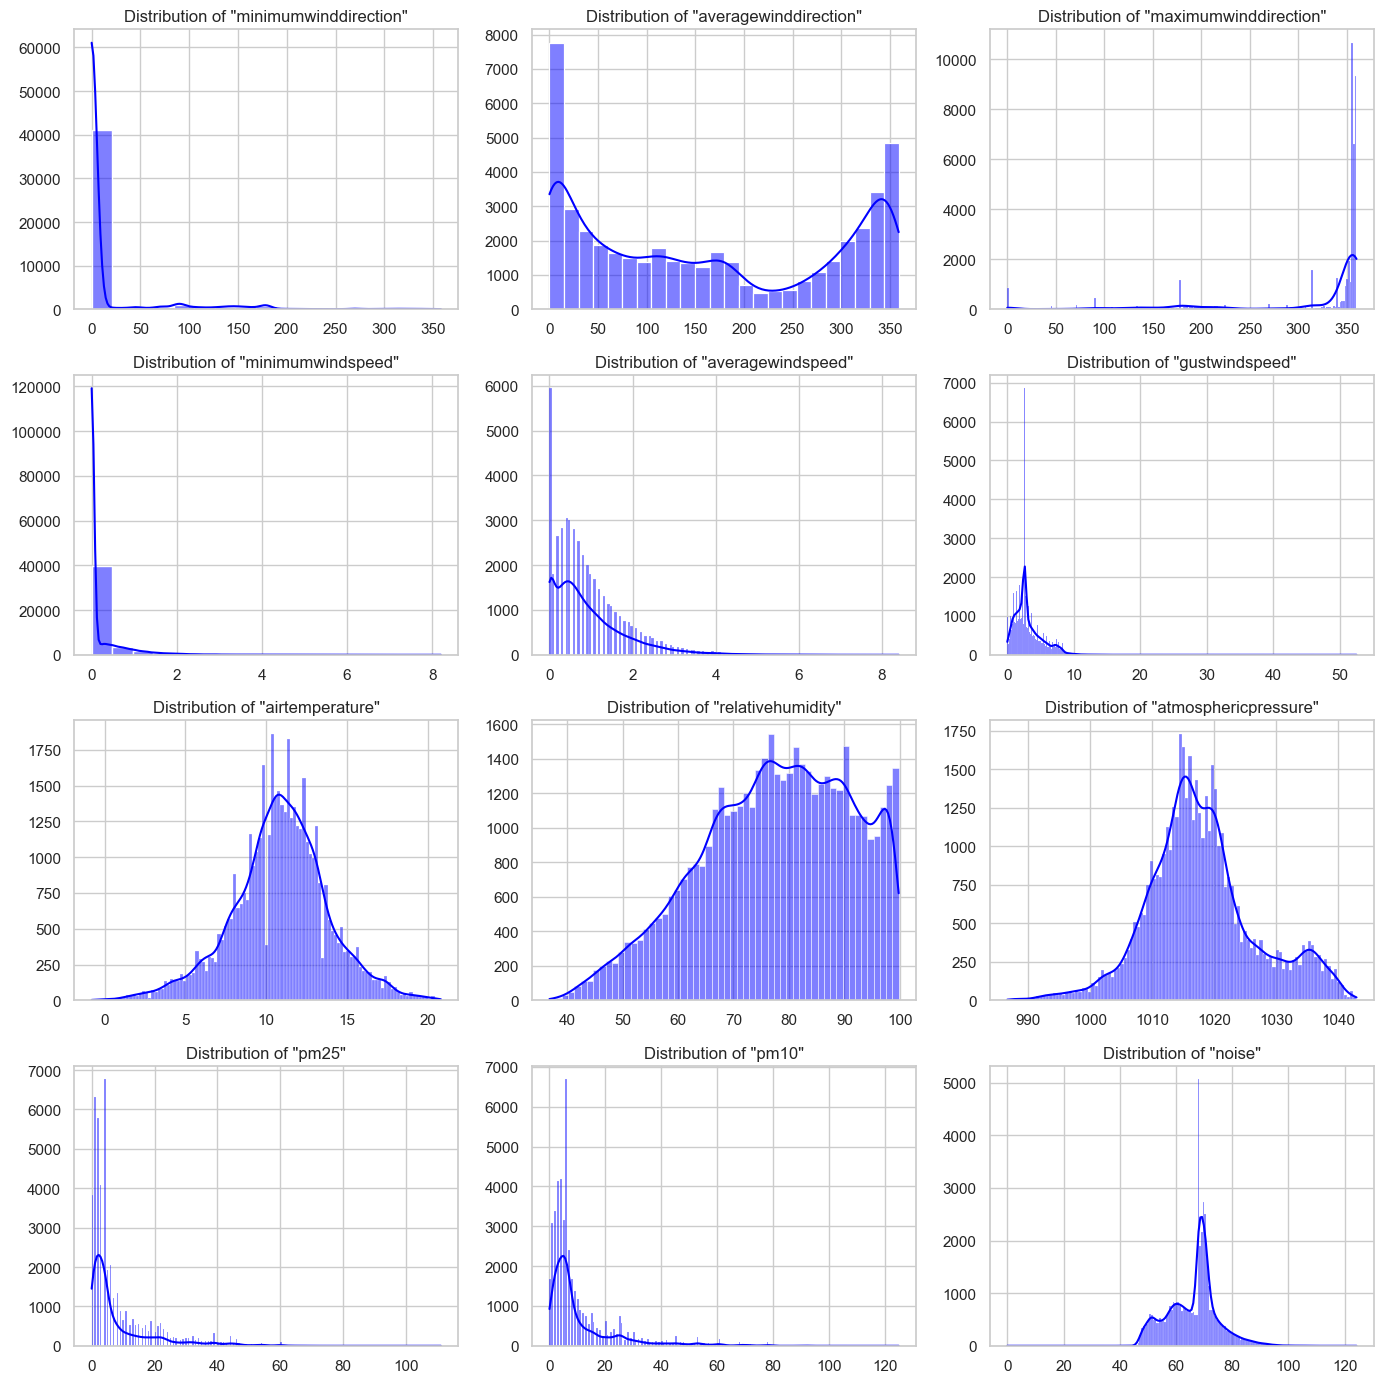

In [6]:
# Setting the aesthetics for the plots
sns.set_theme(style="whitegrid")

# Selecting only the numerical columns for the pairplot
float_columns = [col for col in microclimate_sensors_df.select_dtypes(include=['float64']).columns if col not in ['lat', 'long']]

# Plotting the distribution of key variables
fig, axes = plt.subplots(4, 3, figsize=(14, 14))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, col_name in enumerate(float_columns):
    sns.histplot(microclimate_sensors_df[col_name], kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of "{col_name}"')
    axes[i].set_xlabel('')  # Remove x-axis label
    axes[i].set_ylabel('')  # Remove y-axis label

plt.tight_layout()
plt.show()


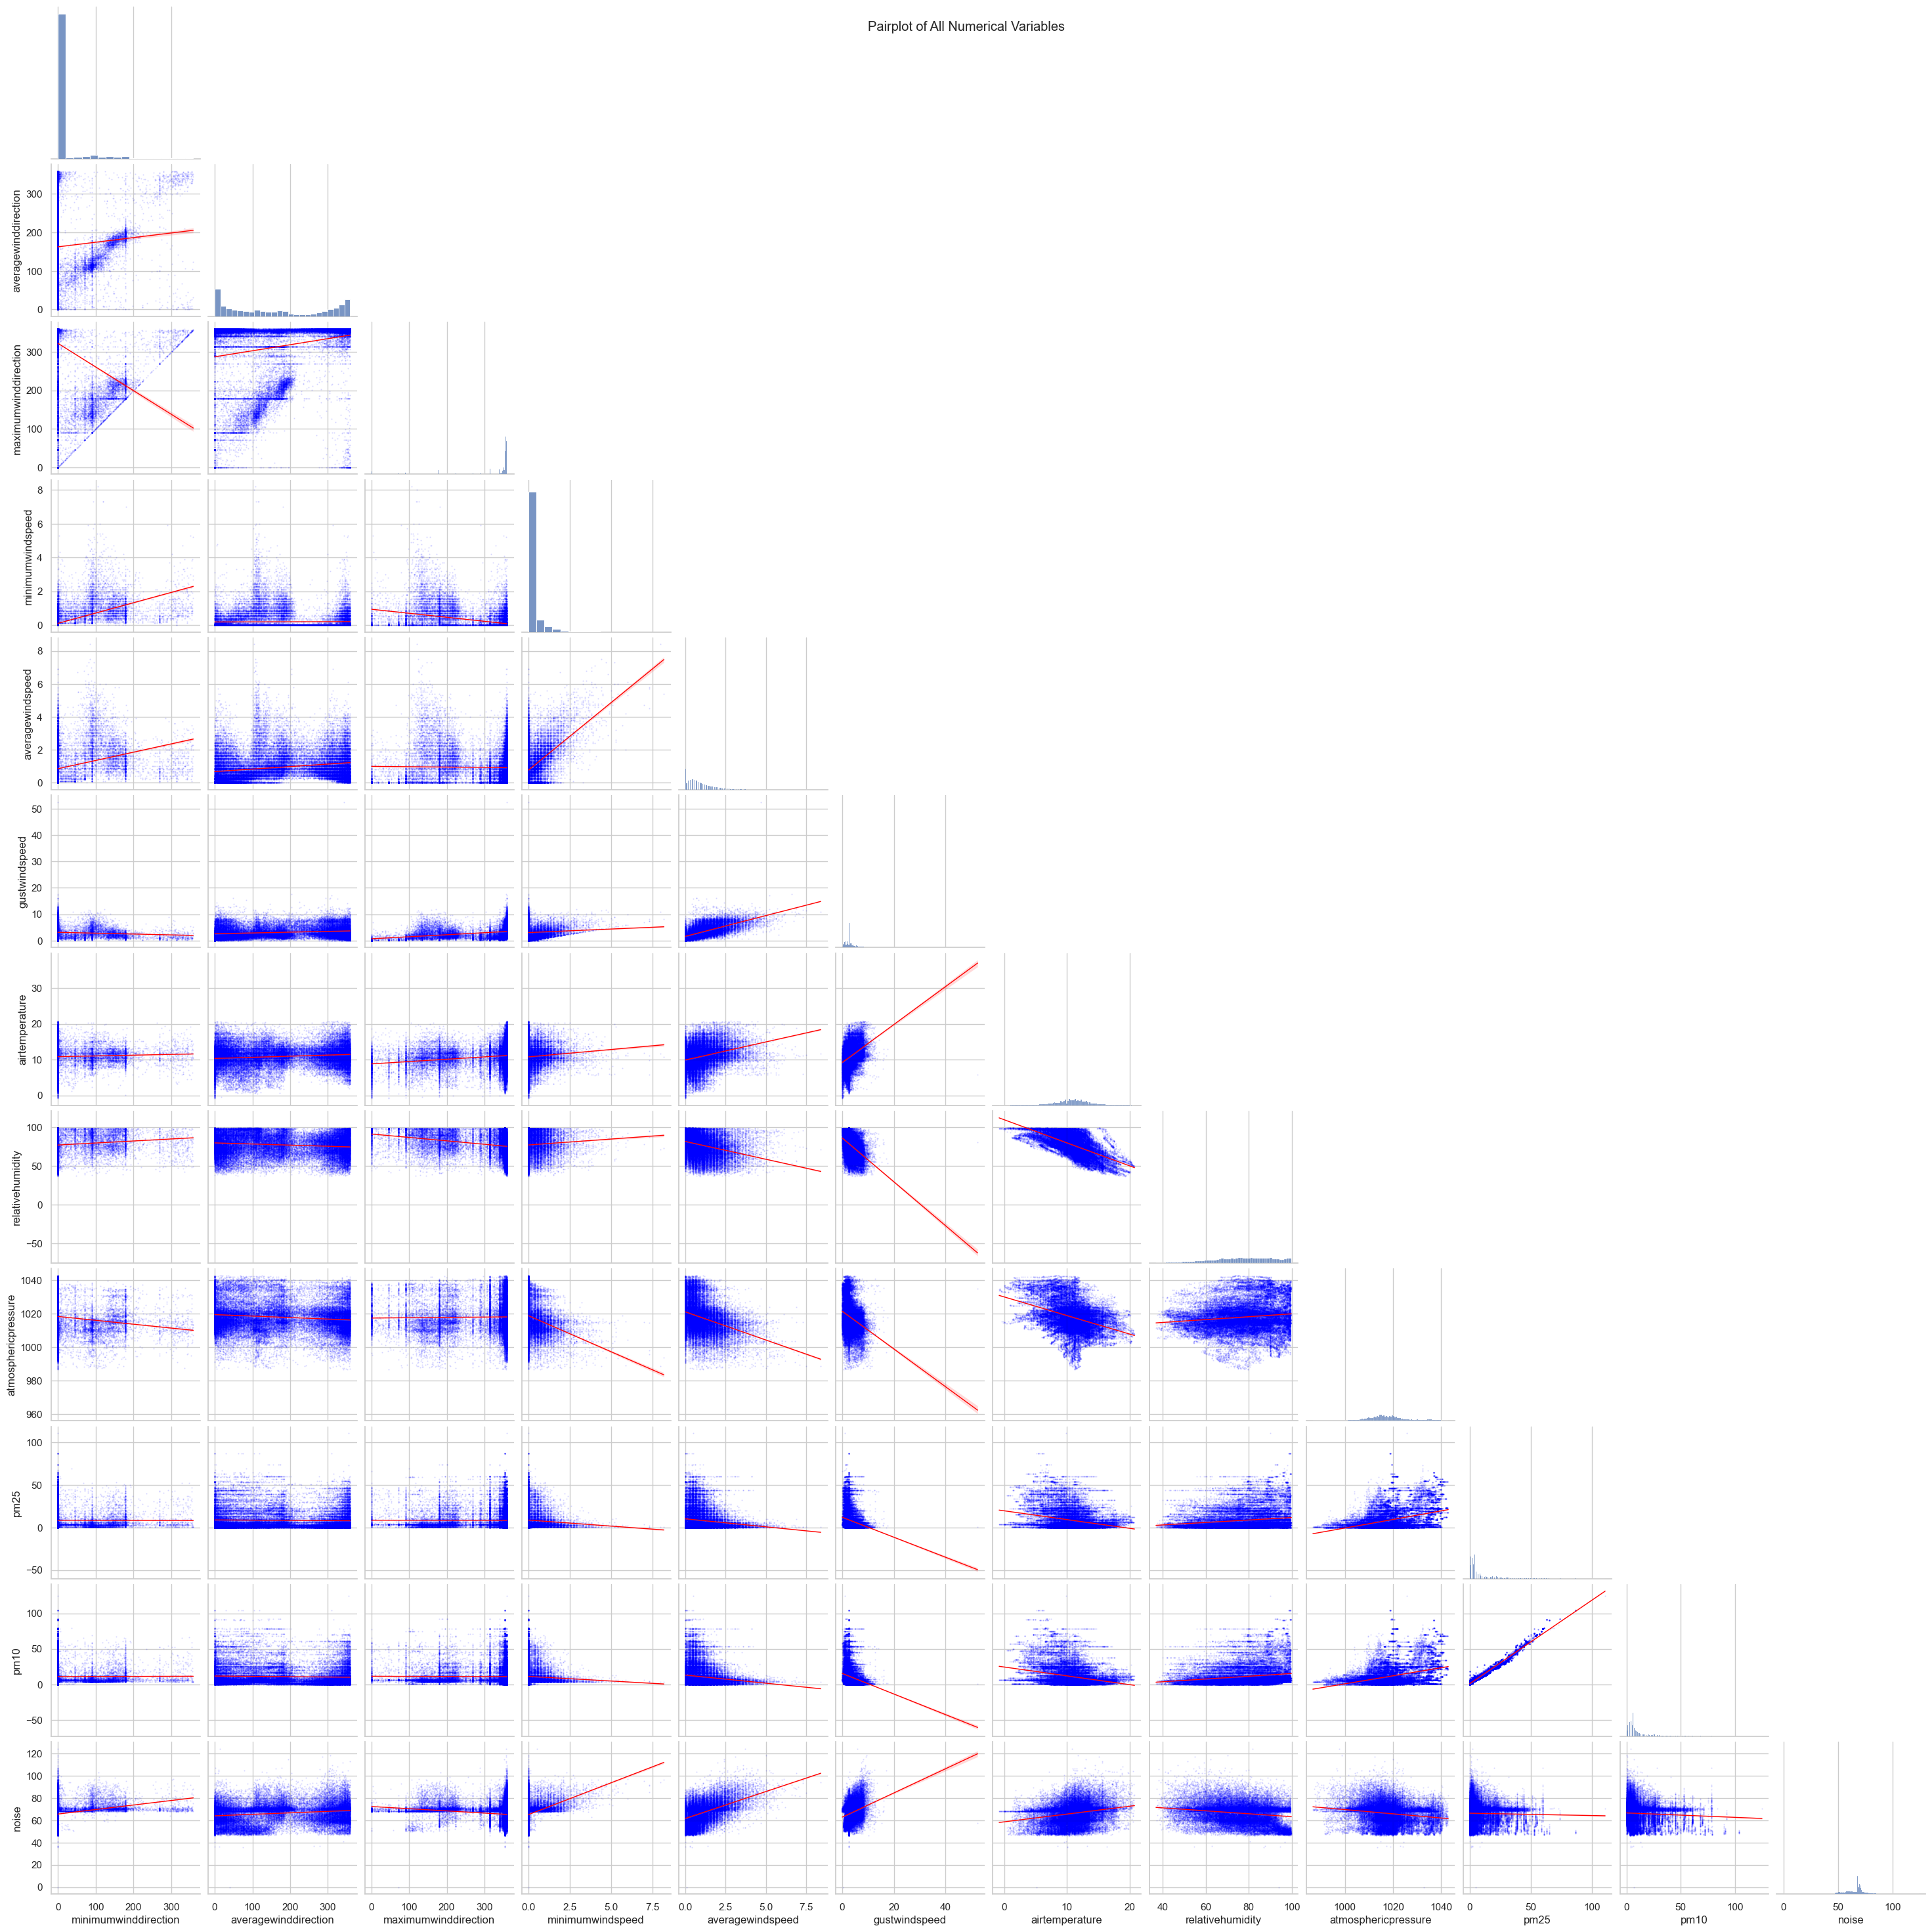

In [8]:
pairplot = sns.pairplot(
    microclimate_sensors_df[float_columns],
    corner=True,
    kind='reg',
    diag_kind='auto',
    plot_kws={'scatter_kws': {'s': 0.5, 'alpha': 0.1, 'color': 'blue'}, 'line_kws': {'color': 'red', 'linewidth': 1}}
)
pairplot.figure.suptitle('Pairplot of All Numerical Variables')
plt.show()

### Argyle Square Air Quality

In [5]:
# Get the second dataset 
argyle_air_quality_df = Get_Dataset('argyle-square-air-quality')
argyle_air_quality_df.head()

,time,dev_id,sensor_name,lat_long,averagespl,carbonmonoxide,humidity,ibatt,nitrogendioxide,ozone,particulateserr,particulatesvsn,peakspl,pm1,pm10,pm25,temperature,vbatt,vpanel
0,2020-06-09T09:02:38+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",56.0,-6448.0,65.0,71.0,287.0,137.0,0.0,151.0,69.0,12.0,19.0,17.0,12.3,3.96,0.00
1,2020-06-09T11:17:37+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",55.0,-6916.0,68.0,89.0,325.0,156.0,0.0,151.0,62.0,15.0,24.0,22.0,10.9,3.93,0.00
2,2022-05-03T21:46:34+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",58.0,-6261.0,77.0,169.0,268.0,137.0,0.0,151.0,64.0,0.0,0.0,0.0,15.1,3.76,16.33
3,2020-06-09T11:32:37+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",55.0,-6916.0,69.0,76.0,325.0,156.0,0.0,151.0,68.0,19.0,29.0,24.0,10.5,3.92,0.00
4,2021-05-15T06:04:33+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",56.0,-6261.0,51.0,12.0,258.0,119.0,0.0,151.0,62.0,0.0,0.0,0.0,14.9,4.01,18.33
